<a href="https://colab.research.google.com/github/aivision2020/NeuralCollectiveUnconsciousness-/blob/main/explore_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an image dataset signal](#section_2)

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features,
                 dataset_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.pos_embedding = SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0)
        self.representations = nn.Embedding(dataset_size, hidden_features)
      
        self.net = [SineLayer(hidden_features, hidden_features, is_first=False, 
                              omega_0=hidden_omega_0)
                for i in range(hidden_layers)]

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords, img_id):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        pos = self.pos_embedding(coords)
        output = self.net(pos + self.representations(img_id))
        return output, coords        


# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [4]:
import glob
import cv2

class ImageFitting(Dataset):
  def __init__(self, data_path, sidelength) -> None:
      super().__init__()
      files = glob.glob(os.path.join(data_path, '*png'))
      transform = Compose([
          Resize(sidelength),
          ToTensor(),
          Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
      self.imgs = [transform(
                    Image.fromarray(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)))
                                  for f in files]
      self.pixels = [img.permute(1, 2, 0).view(-1, 3) for img in self.imgs]
      self.coords = get_mgrid(sidelength, 2)

  def __len__(self):    
    return len(self.imgs)

  def __getitem__(self, i):
    return self.coords, self.pixels[i], torch.ones(len(self.coords))*i

dataset = ImageFitting('/content/drive/MyDrive/dataset/NeuralCollectiveUnconsciousness/Data/48/', 48)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [5]:
dataloader = DataLoader(dataset, batch_size=100, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, dataset_size=len(dataset), outermost_linear=True)
img_siren.cuda()

Siren(
  (pos_embedding): SineLayer(
    (linear): Linear(in_features=2, out_features=256, bias=True)
  )
  (representations): Embedding(100, 256)
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

Step 0, Total loss 0.725543


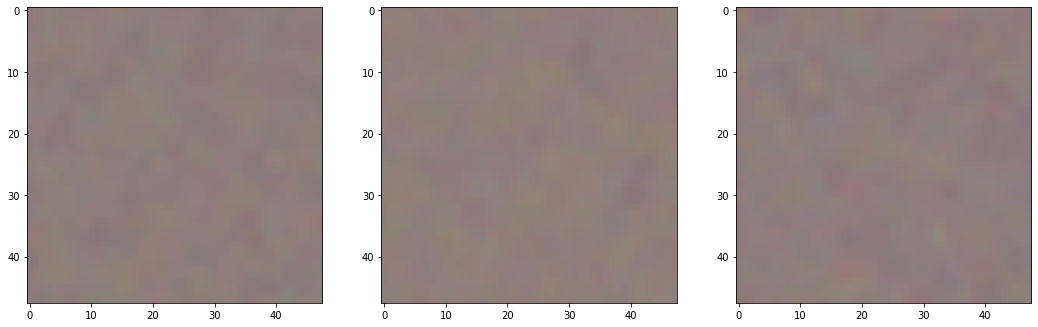

Step 50, Total loss 0.123185


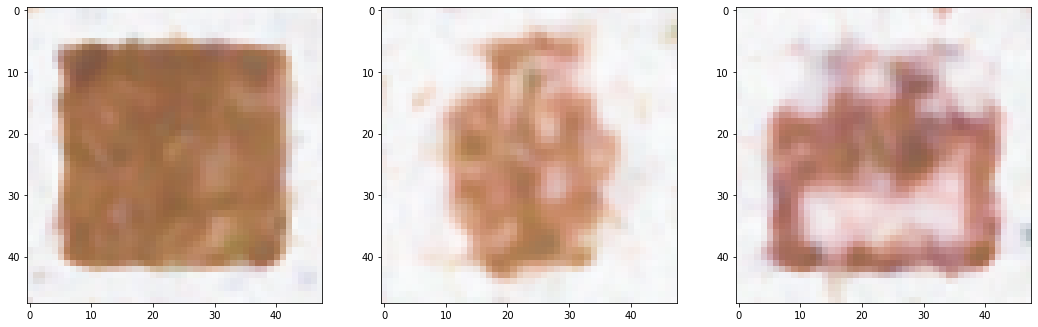

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.031200


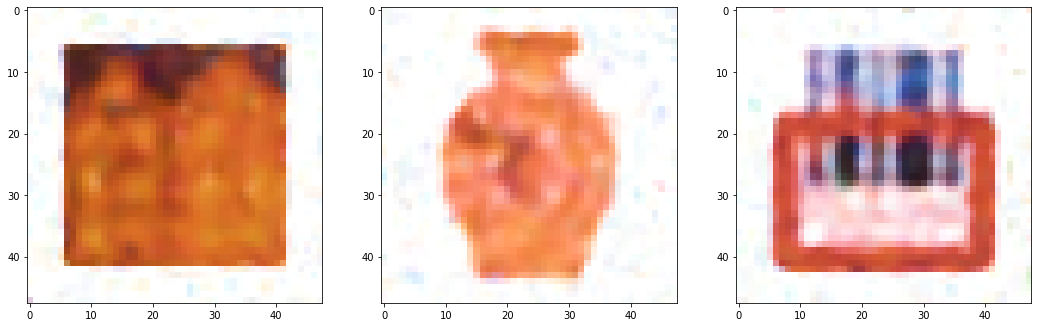

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 150, Total loss 0.015007


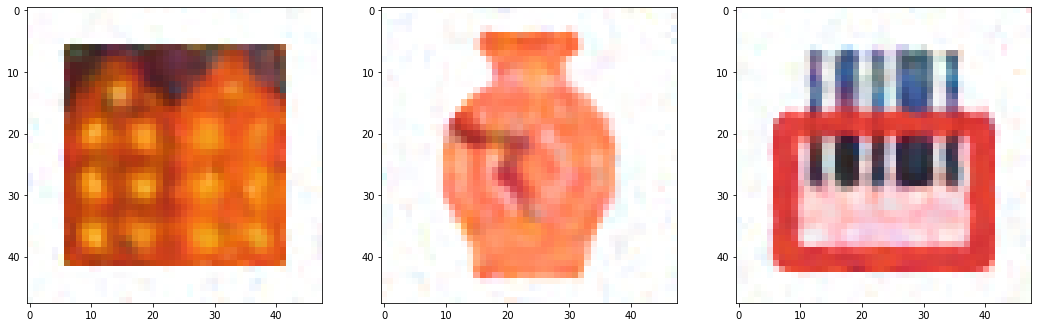

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total loss 0.009286


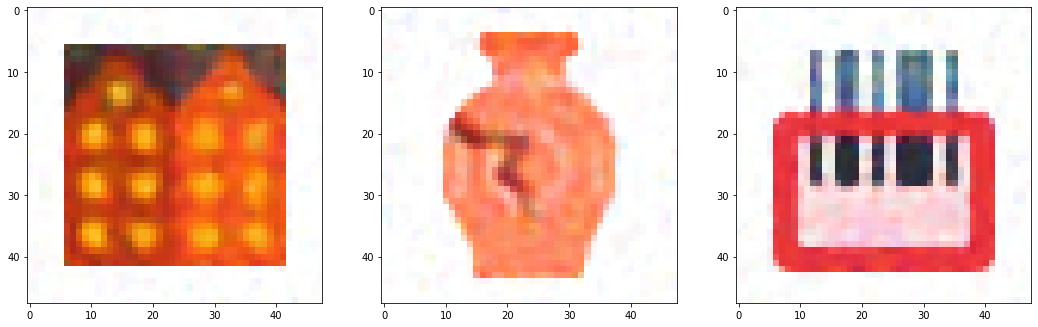

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006485


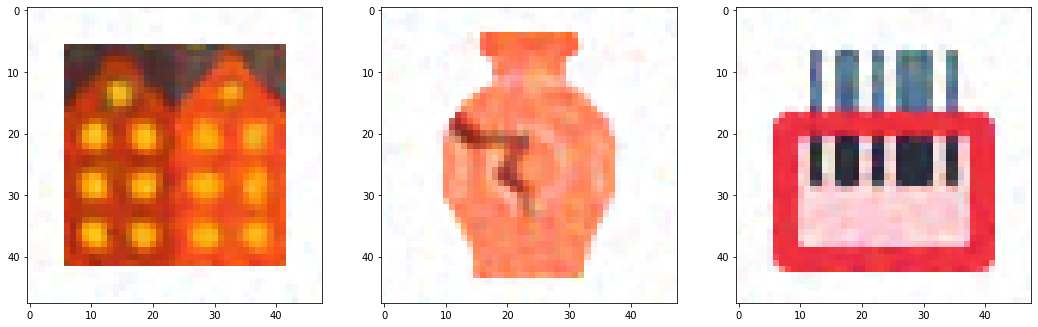

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.004906


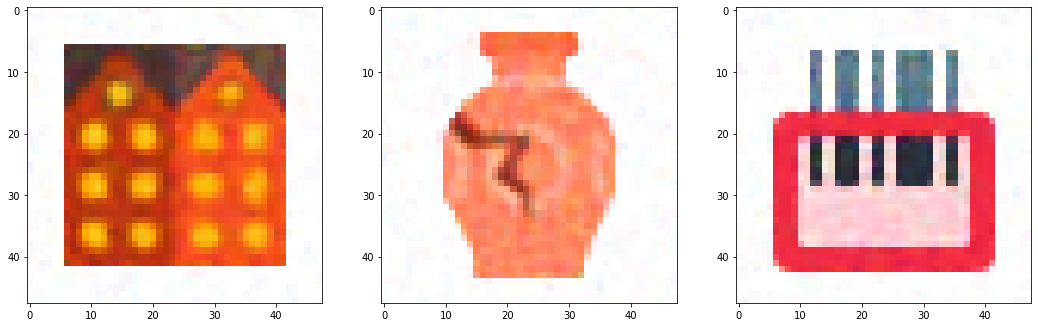

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 350, Total loss 0.004042


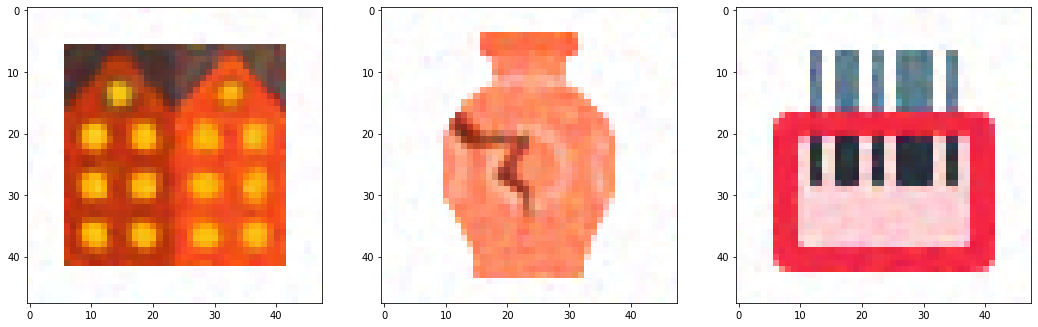

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400, Total loss 0.003288


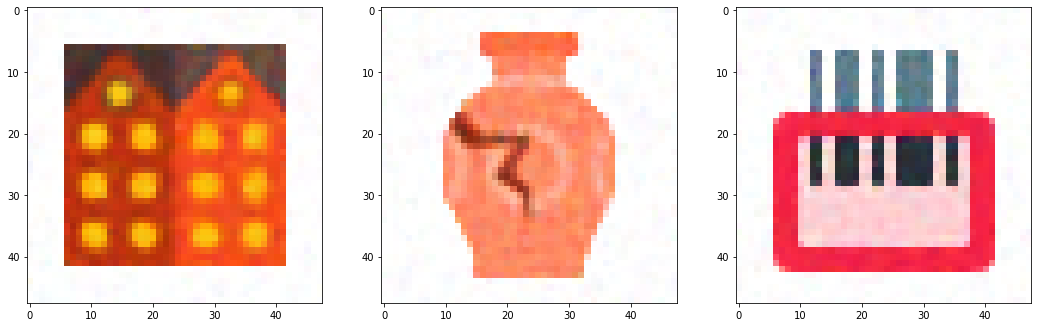

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 450, Total loss 0.002842


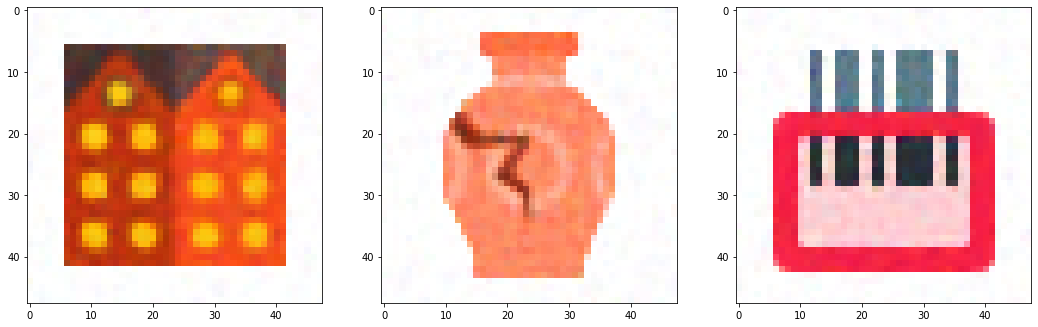

In [6]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

for step in range(total_steps):
  for model_input, ground_truth, im_id in dataloader:
    model_input, ground_truth, im_id = model_input.cuda(), ground_truth.cuda(), im_id.cuda().long()
    model_output, coords = img_siren(model_input, im_id)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if im_id[0,0].item()==0 and not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        
        fig, axes = plt.subplots(1,3, figsize=(18,6))
        
        axes[0].imshow((model_output[0]*0.5+0.5).cpu().view(48, 48, -1).detach().numpy())
        axes[1].imshow((model_output[1]*0.5+0.5).cpu().view(48, 48, -1).detach().numpy())
        axes[2].imshow((model_output[2]*0.5+0.5).cpu().view(48, 48, -1).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


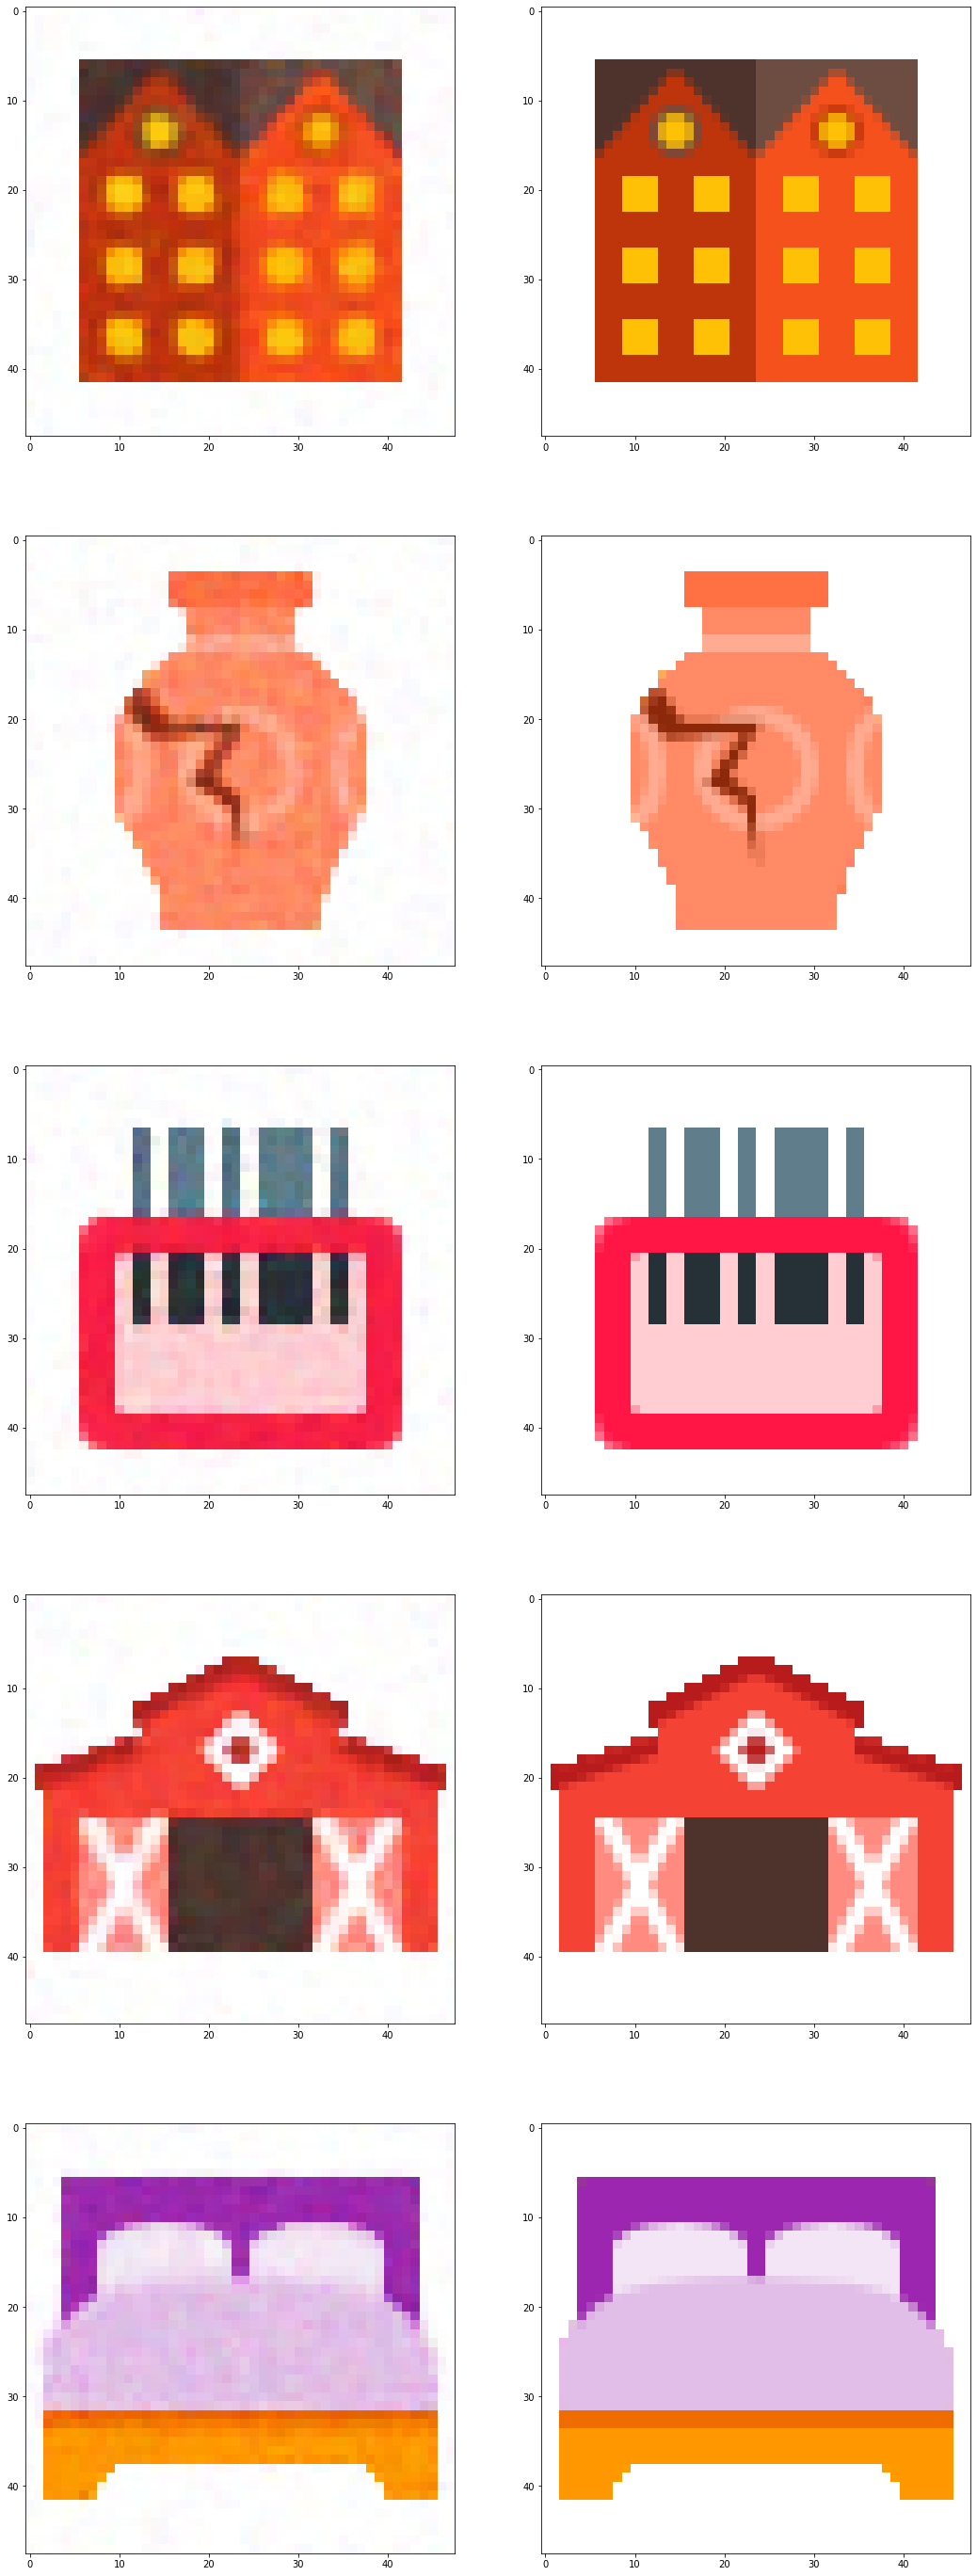

In [7]:
fig, axes = plt.subplots(5,2, figsize=(18,50))
for i in range(5):
    axes[i, 0].imshow((model_output[i]*0.5+0.5).cpu().view(48, 48, -1).detach().numpy())
    axes[i, 1].imshow((ground_truth[i]*0.5+0.5).cpu().view(48, 48, -1).detach().numpy())
plt.show()
